In [1]:
import numpy as np
import igraph as ig
import networkx as nx
import matplotlib.pyplot as plt
import random
import torchvision.datasets as datasets
import mst_tools

from sklearn.decomposition import PCA
from scipy.spatial import distance_matrix

/opt/anaconda3/envs/skenv/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/skenv/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /opt/anaconda3/envs/skenv/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <761A4B43-4CD1-322C-BB16-CEE783FE0A7C> /opt/anaconda3/envs/skenv/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_np = mnist.data.numpy()

In [3]:
data = np.empty((60000,784))
cluster = np.empty(60000)

for i in range(60000):
    data[i,:] = np.squeeze(mnist_np[i].reshape(1,784))
    cluster[i] = mnist[i][1]

In [4]:
n = 1500
p = 300

subsample = random.sample(range(60000), n)

Z = data[subsample,:]
real_labels = cluster[subsample]

pca = PCA(n_components = p)
Z_pca = pca.fit_transform(Z)
Z_dist = distance_matrix(Z_pca, Z_pca)

In [5]:
og_mst = mst_tools.get_mst(Z_dist)
og_tree = mst_tools.get_simple_medoid_mst(Z_dist, og_mst, real_labels)

In [6]:
b = 30
RF_noise = np.empty(b, dtype=float)

count = 0
for i in range(b):
    noise = np.random.multivariate_normal(mean=np.zeros(p),
                                          cov=np.diag(np.repeat(100, p)),
                                          size=n)
    Z_noise = Z_pca + noise
    Z_noise_dist = distance_matrix(Z_noise, Z_noise)
    
    mst = mst_tools.get_mst(Z_noise_dist)
    tree = mst_tools.get_simple_medoid_mst(Z_noise_dist, mst, real_labels)
    network = tree.to_networkx()
    
    RF_noise[count] = mst_tools.RF_dist(og_tree, tree)
    
    count += 1

In [7]:
b = 500
RF_rand = np.empty(b, dtype=float)

count = 0
for i in range(b):
    permutation = np.array(random.sample(range(10), 10))
    labels = permutation[np.array(real_labels, dtype=int)]
    
    tree = mst_tools.get_simple_medoid_mst(Z_dist, og_mst, labels)
    
    RF_rand[count] = mst_tools.RF_dist(og_tree, tree)
    
    count += 1

(array([  1.,   0.,   0.,   0.,   4.,   0.,  54.,   0., 195., 246.]),
 array([0.26666667, 0.3       , 0.33333333, 0.36666667, 0.4       ,
        0.43333333, 0.46666667, 0.5       , 0.53333333, 0.56666667,
        0.6       ]),
 <BarContainer object of 10 artists>)

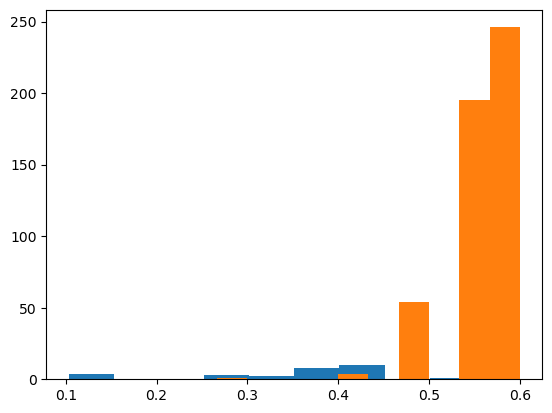

In [8]:
plt.hist(RF_noise)
plt.hist(RF_rand)

In [9]:
np.savetxt('mnist_distances.txt', RF_noise)
np.savetxt('mnist_random.txt', RF_rand)